# Generating k-trees

For a better explanation of the code we will work with the following tree T, we will think of T as a 2-coding tree:  

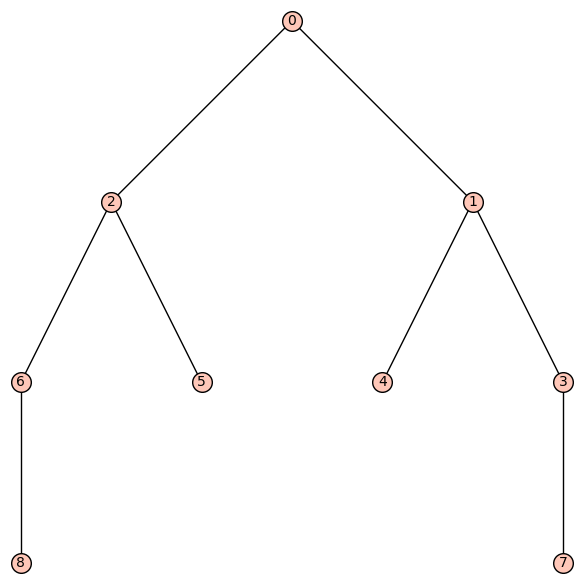

In [128]:
T = Graph()
T.add_edges([(0, 1), (0,2), (1, 3),(3,7), (1, 4), (2, 5), (2, 6),(6,8)])
root=T.center()[0]
V=T.vertices()
nV=len(V)
FirstGenerationV=T.neighbors(root)
T.plot(layout='tree',tree_root=root)


# Lists parent and children

The function "get_family(T,root,nV)" returns two lists:

    · The list "parent", where parent[i] is the parent of the vertex i, the parent of the root is considered -1.  
    · The list of lists "children", where children[i] is the set of children of the vertex i.
    
The lists are computed recursively using the DFS strategy, starting from the root.


In [129]:
def get_family(T,root,nV):
    #Initialize both lists
    parent=[None]*nV
    children = [[] for e in range(nV)]
    #The recursive function that follows DFS
    def visiting(ver,father):
        parent[ver]=father
        for e in T.neighbors(ver):
            if e!=father:
                children[ver].append(e)
                visiting(e,ver)
                
    #Call of the recursive function, starting from the root
    visiting(root,root)

    parent[root]=-1

    return parent,children


For our tree T, the function returns:

In [130]:
parent,children=get_family(T,root,nV)
print(parent)
print(children)

[-1, 0, 0, 1, 1, 2, 2, 3, 6]
[[1, 2], [3, 4], [5, 6], [7], [], [], [8], [], []]


# Lists order and representatives

The function "orderlist(root,children)" returns two lists: 

    · The list "order", which is a list of all vertices except ordered following the DFS strategy.
    · The list "representatives", which contains the representatives of the longest branches of the tree.
    
The lists are computed recursively using the DFS strategy, starting from the root. They have been computed in a different function than the lists parent and children for a better understanding.

In [131]:
def orderlist(root, children):
    
    #"longest_paths" will contain the longests paths starting from the root
    longest_paths = [[root]]
    #Initialize the list order
    order = []
    #The recursive function that follows DFS
    def dfs_order(ver, path, longest_paths):
        #Appending elements to the list order, following DFS strategy
        order.append(ver)
        #Once arrived to a leave
        if children[ver] == []:
            #We check if the path between the root and this leaf is longest one 
            if len(path) > len(longest_paths[0]):
                #If it is the longest path, the the list longes_path will contain only this path
                longest_paths[:]=[]
                longest_paths.append(deepcopy(path))
            #If the path is as long as one of the longest paths
            elif len(path) == len(longest_paths[0]):
                #If it is the case, the path will be appended to the list "longest_paths"
                longest_paths.append(deepcopy(path))
        #If ver is not a leave        
        else:
            #We visit each child of ver and add the child to the list path, 
            #therefore "path", is a path that goes from the root to "child"
            for child in children[ver]:
                
                dfs_order(child, path + [child], longest_paths)
    
    
    #Call of the recursive function, starting from each element of the first generation
    for child1 in children[root]:
        dfs_order(child1, [root, child1], longest_paths)
    
    #We do not need the longest paths but their representatives.
    #The list longbran will contain from the longest paths, the vertices that belong to the first generation
    longbran=[]
    for e in longest_paths:
        longbran.append(e[1])
    #Here, the possible repetitions in the list longbran are removed
    representatives=list(set(longbran))    
    
    return order, representatives

For our tree T, the function returns:

In [132]:

order,representatives=orderlist(root,children)
print(order)
print(representatives)

[1, 3, 7, 4, 2, 5, 6, 8]
[1, 2]


# Computing colorations of a k-coding tree in which the root represents a hedron

The function "coloration_tree_root_hedron" returns a list of suitable colorations, named "colorations", of a coding tree in which the root represents a hedron. An element of "colorations", "coloration", is a list such that coloration[i] is the color assigned to the vertex i, the root is assigned with color -1.

The computation of "coloration_tree_root_hedron" is done by following the DFS strategy and backtracking. We will use the root has label 0.

In [133]:
def coloration_tree_root_hedron(k,root,nV,parent,order,representatives,FirstGenerationV):
    #Initialize the list colorations and the sublist coloration
    colorations=[]
    coloration=[0]*nV
    coloration[root]=-1
    #The list colors, contains all colors from 1 to k+1
    colors=range(1,k+2)
    def findColorings(colors,coloration,i):
        #If we have a suitable color to the last vertex of the tree
        if(coloration[order[-1]]!=0):
            #Save this coloration by appending it to the list "colorations"
            colorations.append(deepcopy(coloration))
            return
        
        #No need for changing colors in the first vertex
        #It will result in a permutation of the colorations already computed
        if i==0:
            c=1
            if(c!=coloration[parent[order[i]]]):
                coloration[order[i]]=c
                findColorings(colors,coloration,i+1)
                coloration[order[i]]=0
                
                
        else:
            for c in colors:
                if(c!=coloration[parent[order[i]]]):
                    #Give the first suitable color to order[i]
                    coloration[order[i]]=c
                    #Continue with the next vertex
                    findColorings(colors,coloration,i+1)
                    #Set the color to 0 again
                    coloration[order[i]]=0
                    
    #Call of the recursive function with i=0
    #The variable i serve as an index for order[i], so order[i] is the vertex we are visiting
    findColorings(colors,coloration,0)

    
    #From all colorations, remove the ones in which the color of all vertices in representatives is the same
    for c in colorations[:]:
        color=c[representatives[0]]
        j=0
        for e in representatives:
            if c[e]!=color:
                j=1
        if j==0:
            colorations.remove(c)
   

    
    
    
    #Remove all colorations that are a permutation of another one
    colorations=remove_permutations(k,colorations)
    
    return colorations

The function "remove_permutations(k,colorations)" removes all colorations that are a permutation of another one in "colorations". 

The function does this by partitionioning the set of vertices by their color, and the comparing partitions between different colorations. If two partitions are the same, then one of their respective colorations is a permutation of the other.

In [134]:
#This function returns the partion of the vertices by coloration
def coloration_listofsets(k,coloration):
    #Initialize a list of sets, each set represents the vertices with that color
    colorlist=[set() for i in range(k+1)]
    #Here we use the root is 0
    #coloration of 0 is -1, we don't have it into account
    #add each vertex to the color set it belongs
    for i in range(1,len(coloration)):
            colorlist[coloration[i]-1].add(i)

    return sorted([tuple(sorted(s)) for s in colorlist])
      
            

def remove_permutations(k,colorations):
    
    uniquepartitions=[]
    uniquecolorations=[]
    for e in colorations:
        #colorlist is the partition of the vertices by the coloration e
        colorlist=coloration_listofsets(k,e)
        if colorlist not in uniquepartitions:
            #If the partition is different we add the coloration to the liste uniquecolorations
            uniquepartitions.append(colorlist)
            uniquecolorations.append(e)

            
    return uniquecolorations

For our tree T, the colorations computed are:

In [135]:
colorations=coloration_tree_root_hedron(2,root,nV,parent,order,longestbranches,FirstGenerationV)
for i in range(len(colorations)):
    print(i,colorations[i])

(0, [-1, 1, 2, 2, 2, 1, 1, 1, 2])
(1, [-1, 1, 2, 2, 2, 1, 1, 1, 3])
(2, [-1, 1, 2, 2, 2, 1, 3, 1, 1])
(3, [-1, 1, 2, 2, 2, 1, 3, 1, 2])
(4, [-1, 1, 2, 2, 2, 3, 1, 1, 2])
(5, [-1, 1, 2, 2, 2, 3, 1, 1, 3])
(6, [-1, 1, 2, 2, 2, 3, 3, 1, 1])
(7, [-1, 1, 2, 2, 2, 3, 3, 1, 2])
(8, [-1, 1, 3, 2, 2, 1, 1, 1, 2])
(9, [-1, 1, 3, 2, 2, 1, 1, 1, 3])
(10, [-1, 1, 3, 2, 2, 1, 2, 1, 1])
(11, [-1, 1, 3, 2, 2, 1, 2, 1, 3])
(12, [-1, 1, 3, 2, 2, 2, 1, 1, 2])
(13, [-1, 1, 3, 2, 2, 2, 1, 1, 3])
(14, [-1, 1, 3, 2, 2, 2, 2, 1, 1])
(15, [-1, 1, 3, 2, 2, 2, 2, 1, 3])
(16, [-1, 1, 2, 2, 3, 1, 1, 1, 2])
(17, [-1, 1, 2, 2, 3, 1, 1, 1, 3])
(18, [-1, 1, 2, 2, 3, 1, 3, 1, 1])
(19, [-1, 1, 2, 2, 3, 1, 3, 1, 2])
(20, [-1, 1, 2, 2, 3, 3, 1, 1, 2])
(21, [-1, 1, 2, 2, 3, 3, 1, 1, 3])
(22, [-1, 1, 2, 2, 3, 3, 3, 1, 1])
(23, [-1, 1, 2, 2, 3, 3, 3, 1, 2])
(24, [-1, 1, 3, 2, 3, 1, 1, 1, 2])
(25, [-1, 1, 3, 2, 3, 1, 1, 1, 3])
(26, [-1, 1, 3, 2, 3, 1, 2, 1, 1])
(27, [-1, 1, 3, 2, 3, 1, 2, 1, 3])
(28, [-1, 1, 3, 2, 3, 2, 1, 1,

# Computing colorations of a k-coding tree in which the root represents a front

Here the children of the root must be colored with the color k+1,the other vertices are colored like before.

The process to color this kind of trees will be the following:

    1. Remove the neighbors/children of the root (FirstGenerationV) from the list order.
    2. Initialize the coloration like before, but now the elements of FirstGenerationV have color k+1.
    3. Compute all colorings of T like before.
 

In [136]:
def coloration_tree_root_front(k,root,nV,parent,order,FirstGenerationV):
    #Step (1)
    frontorder=order[:]
    for e in order:
        if e in FirstGenerationV:
            frontorder.remove(e)

        
    #Step (2)
    colorations=[]
    coloration=[0]*nV
    coloration[root]=-1
    for e in FirstGenerationV:
        coloration[e]=k+1
    #If the tree is a star, color all vertices with k+1
    if len(FirstGenerationV)==nV-1:
        return [coloration]
    #Step (3)
    colors=range(1,k+2)
    def findColorings(colors,coloration,i):
        if(coloration[frontorder[-1]]!=0):
            colorations.append(deepcopy(coloration))
            return

        if i==0:
            c=1
            if(c!=coloration[parent[frontorder[i]]]):
                coloration[frontorder[i]]=c
                #print(coloration)
                findColorings(colors,coloration,i+1)
                coloration[frontorder[i]]=0
                
                
        else:
            for c in colors:
                if(c!=coloration[parent[frontorder[i]]]):
                    coloration[frontorder[i]]=c
                    findColorings(colors,coloration,i+1)
                    coloration[frontorder[i]]=0
                    
    findColorings(colors,coloration,0)
    #Remove permutations
    colorations=remove_permutations(k,colorations)
    
    return colorations

For our tree T, the colorations computed are:

In [137]:
colorationsfront=coloration_tree_root_front(2,root,nV,parent,order,FirstGenerationV)
for i in range(len(colorationsfront)):
    print(i,colorationsfront[i])

(0, [-1, 3, 3, 1, 1, 1, 1, 2, 2])
(1, [-1, 3, 3, 1, 1, 1, 1, 2, 3])
(2, [-1, 3, 3, 1, 1, 1, 2, 2, 1])
(3, [-1, 3, 3, 1, 1, 1, 2, 2, 3])
(4, [-1, 3, 3, 1, 1, 2, 1, 2, 2])
(5, [-1, 3, 3, 1, 1, 2, 1, 2, 3])
(6, [-1, 3, 3, 1, 1, 2, 2, 2, 1])
(7, [-1, 3, 3, 1, 1, 2, 2, 2, 3])
(8, [-1, 3, 3, 1, 2, 1, 1, 2, 2])
(9, [-1, 3, 3, 1, 2, 1, 1, 2, 3])
(10, [-1, 3, 3, 1, 2, 1, 2, 2, 1])
(11, [-1, 3, 3, 1, 2, 1, 2, 2, 3])
(12, [-1, 3, 3, 1, 2, 2, 1, 2, 2])
(13, [-1, 3, 3, 1, 2, 2, 1, 2, 3])
(14, [-1, 3, 3, 1, 2, 2, 2, 2, 1])
(15, [-1, 3, 3, 1, 2, 2, 2, 2, 3])
(16, [-1, 3, 3, 1, 1, 1, 1, 3, 2])
(17, [-1, 3, 3, 1, 1, 1, 1, 3, 3])
(18, [-1, 3, 3, 1, 1, 1, 2, 3, 1])
(19, [-1, 3, 3, 1, 1, 1, 2, 3, 3])
(20, [-1, 3, 3, 1, 1, 2, 1, 3, 2])
(21, [-1, 3, 3, 1, 1, 2, 1, 3, 3])
(22, [-1, 3, 3, 1, 1, 2, 2, 3, 1])
(23, [-1, 3, 3, 1, 1, 2, 2, 3, 3])
(24, [-1, 3, 3, 1, 2, 1, 1, 3, 2])
(25, [-1, 3, 3, 1, 2, 1, 1, 3, 3])
(26, [-1, 3, 3, 1, 2, 1, 2, 3, 1])
(27, [-1, 3, 3, 1, 2, 1, 2, 3, 3])
(28, [-1, 3, 3, 1, 2, 2, 1, 3,

# Decoding  a k-coding tree where the root represents a hedron 

The code is as stated in the pdf file of the thesis, so no comments are added.

In [138]:
def decoding_root_hedron(k,root,coloration,children):
    k1=k+1
    veradjacent=range(k1)
    #CompleteGraph(k+1) method returns a complete graph labeled from 0 to k
    G=graphs.CompleteGraph(k1)
    
    def add_hedrons(veradjacent,ver):
        if(children[ver]==[]):
            kver=ver+k
            c=coloration[ver]
            l=range(k1)
            l.remove(c-1)
            for i in l:
                G.add_edge(kver,veradjacent[i])
            return    
        
        
        for v in children[ver]:
            kv=v+k
            c=coloration[v]
            l=range(k1)
            l.remove(c-1)
            for i in l:
                G.add_edge(kv,veradjacent[i])
            aux=veradjacent[c-1]
            veradjacent[c-1]=kv
            add_hedrons(veradjacent,v)
            veradjacent[c-1]=aux
        
    add_hedrons(veradjacent,root)
    return G
    

A representation of the graph when decoding T with coloration=[-1, 1, 2, 2, 2, 1, 1, 1, 2].

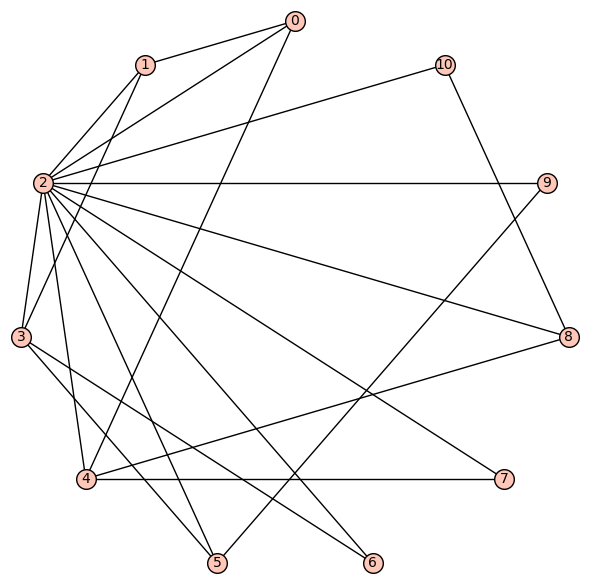

In [139]:
coloration=[-1, 1, 2, 2, 2, 1, 1, 1, 2]
ktree=decoding_root_hedron(2,root,coloration,children)
ktree.plot(layout='circular')

# Decoding  a k-coding tree where the root represents a front 

The code is as stated in the pdf file of the thesis, so no comments are added.

In [140]:
def decoding_root_front(k,root,coloration,children):
    k1=k+1
    veradjacent=range(k)
    G=graphs.CompleteGraph(k)
    
    def add_hedrons(veradjacent,ver):
        if(children[ver]==[]):
            #For this operation we need the center of the tree to be the 0, it makes things easier
            #This way we don't have to relabel the complete graphs or by other ways
            kver=ver+k-1
            c=coloration[ver]
            l=range(k1)
            l.remove(c-1)
            for e in l:
                G.add_edge(kver,veradjacent[e])
            return

        
        for v in children[ver]:
            kv=v+k-1
            c=coloration[v]
            l=range(k1)
            l.remove(c-1)

            for e in l:
                G.add_edge(kv,veradjacent[e])
            aux=veradjacent[c-1]
            veradjacent[c-1]=kv
            add_hedrons(veradjacent,v)
            veradjacent[c-1]=aux


    for v in children[root]:
        kv=v+k-1
        veradjacent=range(k)
        for e in veradjacent:
            G.add_edge(kv,e)
        veradjacent.append(kv)
        add_hedrons(veradjacent,v)
    return G

A representation of the graph when decoding T with colorationf=[-1, 3, 3, 1, 1, 1, 1, 2, 2].

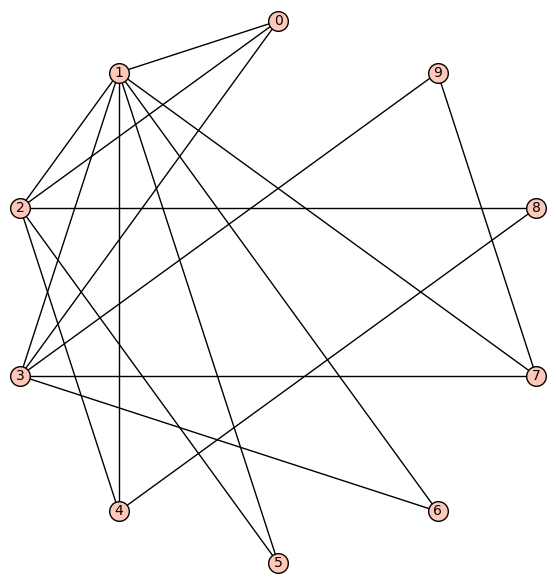

In [141]:
colorationf=[-1, 3, 3, 1, 1, 1, 1, 2, 2]
ktreef=decoding_root_front(2,root,colorationf,children)
ktreef.plot(layout='circular')

# Coding k-trees

    1. Remove all simplicial vertices from H, and save them in L.

    2. Remove all simplicial vertices from H. For each removed vertex kv, identify the set of vertices in L that are adjacent to kv in G. Then, we join all vertices from this set to kv in T, and kv is added to L, while the vertices from the set are removed from L. If the set is empty, then the vertex is added to L directly.
  
    3. Repeat (2) until H is either a front or a hedron.

    4. All vertices in L are joined to the root, where the label r is not in V(G)\setminus V(H_G).

    5. Give a coloration of G.

    6. For each vertex v_k of V(T)\{root}, the mapping c is defined by c(kv) equals the color of kv in G.

    7. The algorithm returns (T,c,k)

In [142]:
def coding_ktrees(G,k):
    from sage.graphs.graph_coloring import first_coloring
    n=len(G.vertices())
    
    T=Graph()
    
    H=copy(G)
    #Step (1,2,3)
    L=[]
    while len(H.vertices())>(k+1):
        for e in H.vertices():
            if H.degree(e)==k:
                H.delete_vertex(e)
                for ver in L[:]:
                    if G.has_edge(ver,e):
                        T.add_edge(ver,e)
                        L.remove(ver)
                L.append(e)
    #Step (4)
    #The remaning vertices of L are the children of the root, we will name it as n, no vertex in the G has that name
    for e in L:
        T.add_edge(e,n)
    
    #Step (5)
    
    """
    first_coloring returns a list of lists, each list is the set of vertices of one color.
    The set of vertices of the first list will have color 1, the set of the second list color 2 ...(until k+1)
    We will use the type of colorations we have been using until now.
    
    """
    colorG=first_coloring(G,k+1)
    
    """
    In the fucntion "decoding_root_front" we use that the children of the root have color k+1.
    So it would be useful to transpose one of the lists, for a possible future use of the coding tree, the one that contains the first child of the root,
    with last one.
    """ 
    firstchild=T.neighbors(n)[0]
    colorfirstchild=k
    for i in range(k):
        if firstchild in colorG[i]:
            colorfirstchild=i
            
    aux=colorG[k]
    colorG[k]=colorG[colorfirstchild]
    colorG[colorfirstchild]=aux
    
    """
    As said before we convert colorG to our type of coloration, following the order given by colorG.
    coloration has length n+1 vertices like G plus the root (color -1), 
    after this we want to move all colors to the first n_T colors, having this way
    the T colored and relabeled between 0 and n_T-1
    """
    coloration=[0]*(n+1)
    coloration[n]=-1
    
    for i in range(k+1):
        for j in colorG[i]:
            coloration[j]=i+1
    
    n_T=len(T.vertices())
    """
    kt2vertices are the vertices of the root, have color 0. We want all those vertices at the end of the list,
    so if they are already at the end we leave them there (we remove them from kt2vertices, to forget about them)
    """
    kt2vertices=H.vertices()
    for i in kt2vertices[:]:
        coloration[i]=0
        #if one color of the root is in its future place, leave it there
        if i>=n_T:
            kt2vertices.remove(i)

    
    p=0
    for i in range(n_T,n+1):
        if coloration[i]!=0:
            coloration[kt2vertices[p]]=coloration[i]
            coloration[i]=0
            T.relabel({i:kt2vertices[p],kt2vertices[p]:i})
            p+=1 
            
    #Now we make one last transposition to rename the root as 0
    #As before, it can be usedul for a future use of the coding tree
    root=coloration.index(-1)
    coloration[root]=coloration[0]
    coloration[0]=-1
    T.relabel({0:root,root:0})
    
    return T,coloration[:n_T]


A representation of the coding tree resulting from decoding a previously computed ktree.

[-1, 1, 3, 3, 1, 1, 1, 3, 3]


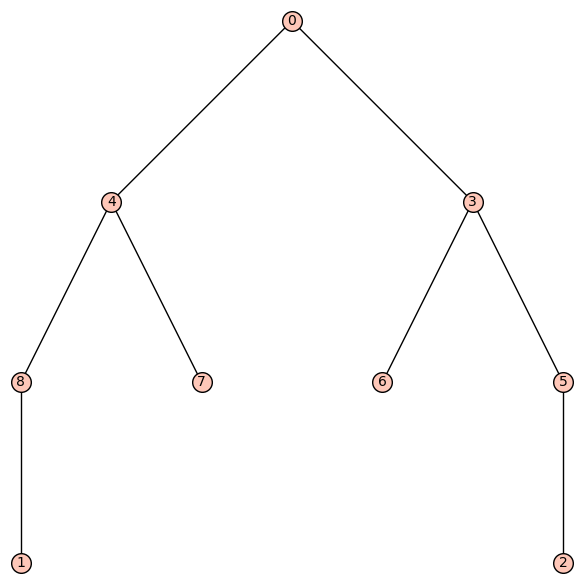

In [143]:
ctree,colorsctree= coding_ktrees(ktree,2)
print(colorsctree)
ctree.plot(layout="tree")

# Generating k-trees

The function "generating_ktrees(k,n)" returns a list with all non-isomorphic k-trees with n vertices

In [144]:
def generating_ktrees(k,n):
    from sage.graphs.trees import TreeIterator
    #ktrees is the list where all unlabeled k-trees with n vertices are stored
    ktrees=[]
    """
    Here we compute all trees with n-k vertices in which the center is a single vertex, the root
    which represents a hedron. We compute these trees by means of the TreeIterator method.
    """
    for T in TreeIterator(n-k):
        if len(T.center())==1:
            """
            The list ktrees_T contains all non-isomorphic k-trees 
            obtained by decoding the tree T with different colorations.
            
            """
            ktrees_T=[]
            V=T.vertices()
            nV=len(V)
            root=T.center()[0]
            T.relabel({root:0,0:root})
            root=0
            FirstGenerationV=T.neighbors(0)
            parent,children=get_family(T,0,nV)
            order,representatives=orderlist(0,children)
            colorations=coloration_tree_root_hedron(k,0,nV,parent,order,representatives,FirstGenerationV)
            for e in colorations:
                p=0
                #For all colorations decode the coding tree
                ktree=decoding_root_hedron(k,root,e,children)
                for i in ktrees_T:
                    if ktree.is_isomorphic(i):
                        p=1
                        break
                if p==0:
                    #If "ktree" is not isomorphic to any other k-tree in "ktrees_T", then append it in "ktrees_T"
                    ktrees_T.append(ktree)
           
            ktrees=ktrees+ktrees_T[:]
            
            
            
       
          
      
    #This is the same but now the root represents a front
    for T in TreeIterator(n-k+1):
        if len(T.center())==1:
            ktrees_T=[]
            V=T.vertices()
            nV=len(V)
            root=T.center()[0]
            T.relabel({root:0,0:root})
            root=0
            FirstGenerationV=T.neighbors(root)
            parent,children=get_family(T,root,nV)
            order,representatives=orderlist(root,children)
            colorations=coloration_tree_root_front(k,root,nV,parent,order,FirstGenerationV)
            for e in colorations:
                p=0
                ktree=decoding_root_front(k,root,e,children)
                for i in ktrees_T:
                    if ktree.is_isomorphic(i):
                        p=1
                        break
                if p==0:
                    ktrees_T.append(ktree)
            
            ktrees=ktrees+ktrees_T[:]
            
            
    
    
    return ktrees
    

Here, an example using the function is presented.

In [145]:
ktrees=generating_ktrees(3,10)
print(len(ktrees))

275
